In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Replace with your chosen model
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Data paths (replace with your actual file paths)
cry_data_path = r"C:\Users\Lenovo\cryanalysis\lib\cry\All cleaned"
non_cry_data_path = r"C:\Users\Lenovo\cryanalysis\lib\cry\Not Cry"

# Feature extraction function
def extract_features(audio_file, max_length=100):
    audiofile, sr = librosa.load(audio_file)
    fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc= 2000)
    if fingerprint.shape[1] < max_length:
        pad_width = max_length - fingerprint.shape[1]
        fingerprint_padded = np.pad(fingerprint, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return fingerprint_padded.T
    elif fingerprint.shape[1] > max_length:
        return fingerprint[:, :max_length].T
    else:
        return fingerprint.T

# Load data and extract features
X = []  # Feature vectors
y = []  # Labels
max_length = 100

# Extract features from cry recordings
for filename in os.listdir(cry_data_path):
    filepath = os.path.join(cry_data_path, filename)
    features = extract_features(filepath)
    X.append(features)
    y.append(1)  # Label as cry (1)

# Extract features from non-cry recordings
for filename in os.listdir(non_cry_data_path):
    filepath = os.path.join(non_cry_data_path, filename)
    features = extract_features(filepath)
    X.append(features)
    y.append(0)  # Label as non-cry (0)


In [2]:

# Convert to numpy arrays
X = np.asarray(X)
y = np.asarray(y)

# Flatten the features and labels
X_flat = X.reshape(X.shape[0], -1)
y_flat = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2,random_state=42,stratify=y_flat)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
    }

# Assuming X_res and y_res are your resampled datasets
# Perform Randomized Search with Cross-Validation
randomized_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=10,  # Number of random combinations to try
    cv=5,
    scoring='accuracy',
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the model
randomized_search.fit(X_train, y_train)

# Output the best parameters and score
print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validated score: {randomized_search.best_score_}")

# You can also retrieve the best model
best_model = randomized_search.best_estimator_
print(f"Best model: {randomized_search.best_estimator_}")


Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best cross-validated score: 0.9669335518850083
Best model: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)


In [ ]:
# Train the model 
from sklearn.model_selection import learning_curve


model = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
train_sizes, train_scores, test_scores = learning_curve(
            model,
            X_train,
            y_train,
            cv=5,
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10)  # 10 different training sizes
        )

        # Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange')

        # Plot confidence intervals
plt.fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1, color='blue')
plt.fill_between(train_sizes,
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.1, color='orange')

        # Label the plot
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves (Random Forest)')
plt.legend(loc='best')
plt.grid()
plt.show()

# Save the model
model_path = r"C:\Users\Lenovo\cryanalysis\lib\cry\cry2.pkl"
joblib.dump(model, model_path)
print("Model saved to:", model_path)

Accuracy: 0.966321243523316
Model saved to: C:\Users\Lenovo\cryanalysis\lib\cry\cry2.pkl


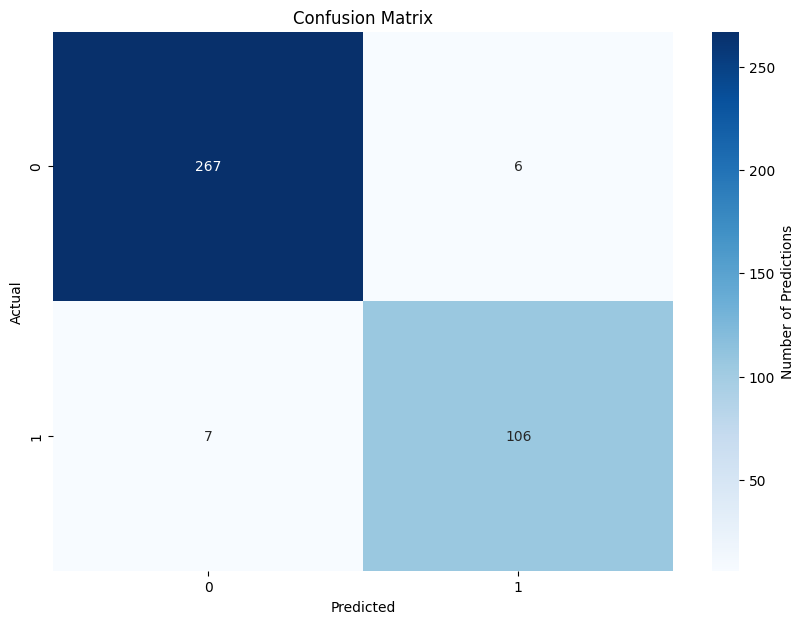

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       273
           1       0.95      0.94      0.94       113

    accuracy                           0.97       386
   macro avg       0.96      0.96      0.96       386
weighted avg       0.97      0.97      0.97       386



Text(0.5, 1.0, 'Performance Metrics Heatmap (Precision, Recall, F1-score, Accuracy)')

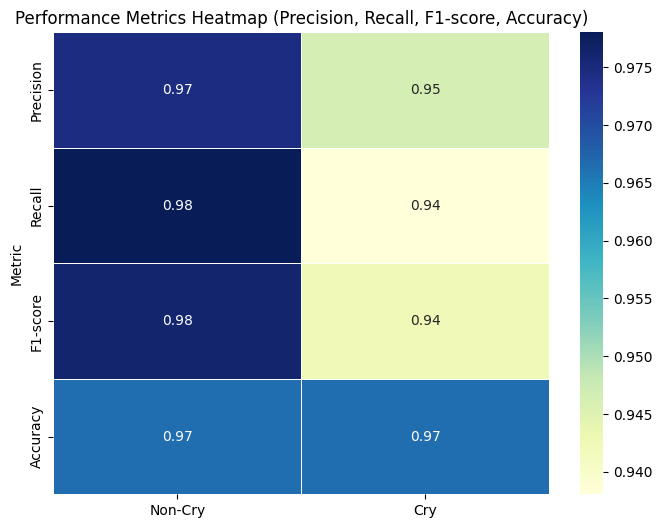

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
# Confusion Matrix Visualization 
    
cm = confusion_matrix(y_test, predictions, labels=sorted(set(y_test)))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)), 
            cbar_kws={'label': 'Number of Predictions'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, predictions))

report = classification_report(y_test, predictions, target_names=['Non-Cry', 'Cry'], output_dict=True)

# Convert the report into a DataFrame (Exclude 'accuracy' row)
df_report = pd.DataFrame(report).iloc[:-1, :-2]

# Create a new DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Non-Cry': [df_report.at['precision', 'Non-Cry'], df_report.at['recall', 'Non-Cry'], df_report.at['f1-score', 'Non-Cry'], accuracy],
    'Cry': [df_report.at['precision', 'Cry'], df_report.at['recall', 'Cry'], df_report.at['f1-score', 'Cry'], accuracy]
})


# Set 'Metric' as the index
metrics_df.set_index('Metric', inplace=True)


# Plot the heatmap of precision, recall, and f1-score
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Performance Metrics Heatmap (Precision, Recall, F1-score, Accuracy)')

# Prediction Test

In [ ]:
# Function to predict cry for new audio
def predict_cry(audio_path, model_path=model_path):
    # Load and pre-process the audio
    y, sr = librosa.load(audio_path)
    # Extract features
    features = extract_features(audio_path)
    # Reshape features if necessary
    features = features.reshape(1, -1)
    # Load the trained model
    model = joblib.load(model_path)
    # Make prediction
    prediction = model.predict(features)
    if prediction[0] == 1:
        print("Cry detected!")
    else:
        print("No cry detected.")

# Example usage
new_audio_path = r"C:\Users\Lenovo\cryanalysis\lib\cry\Not Cry\1-7057-A-12.wav"
predict_cry(new_audio_path)